# Sequential Decision Analytics
---

# Adaptive Market Planning

In [231]:
import numpy as np
import matplotlib.pyplot as plt

In [232]:
# Define the model for adaptive market planning
class AdaptiveMarketPlanningModel:
    def __init__(self, state_names, decision_names, init_state, T, reward_type, price, cost):
        self.state_names = state_names # Names of the state variables
        self.decision_names = decision_names # Names of the decision variables
        self.init_state = init_state # Initial state of the model
        self.state = init_state.copy() # Current state, copied from initial state
        self.T = T # Training period
        self.price = price # Selling price per unit
        self.cost = cost # Cost per unit
        self.learning_list = [] # List of track learning progress

    # Define the step function to execute an action and update the state
    def step(self, action):
        self.state['order_quantity'] = max(0, self.state['order_quantity'] + action) # Update order quantity, ensuring it remains non-negative
        self.state['counter'] += 1 # Increment the counter
        reward = (self.price - self.cost) * self.state['order_quantity'] #Calculate reward as profit
        self.learning_list.append(self.state['order_quantity']) # Trach the order quantity
        return reward
    
    # Reset the state to the intial state
    def reset(self):
        self.state = self.init_state.copy()
        self.learning_list = [] # Clear the learning list

In [233]:
# Define the policy for adaptive market planning using Q-learning
class AdaptiveMarketPlanningPolicy:
    def __init__(self, model, alpha, gamma, epsilon, epsilon_decay, alpha_decay):
        self.model = model # Model instance
        self.alpha = alpha # Learning rate
        self.gamma = gamma # Discount factor
        self.epsilon = epsilon # Exploration rate
        self.epsilon_decay = epsilon_decay # Decay factor for exploration rate
        self.alpha_decay = alpha_decay # Decay factor for learning rate
        self.q_table = {} # Initialize Q-tatble
        self.init_q_table() # Populate Q-table

    # Initialize Q-table with default values
    def init_q_table(self):
        for order_quantity in range(0, 200):
            self.q_table[order_quantity] = 0

    # Ensure that the state is in the Q-table
    def ensure_state_in_q_table(self, state):
        if state not in self.q_table:
            self.q_table[state] = 0
    
    # Choose an action based on the current state and exploration-exploitation strategy
    def choose_action(self, state):
        if np.random.rand() < self.epsilon: # Explore
            action = np.random.choice([-0.5, 0.5, -1, 1]) # Random action
        else: # Exploit
            action = 0.5 if self.q_table[state] > 0 else -0.5 # Best known action
        return action
    
    # Update the Q-table based on the state, reward, and next state
    def update_q_table(self, state, reward, next_state):
        self.ensure_state_in_q_table(state) # Ensure current state is in Q-table
        self.ensure_state_in_q_table(next_state) # Ensure next state is in Q-table
        best_next_action = 0.5 if self.q_table[next_state] > 0 else -0.5 # determine best next action
        td_target = reward + self.gamma * self.q_table[next_state] # Calculate TD target
        td_error = td_target - self.q_table[state] # Calculate TD error
        self.q_table[state] += self.alpha * td_error # Update Q-value
    
    # Run the policy for a specified number of steps
    def run_policy(self):
        total_reward = 0
        state = self.model.state['order_quantity'] # Initialize state
        for t in range(self.model.T):
            action = self.choose_action(state) # Choose an action
            reward = self.model.step(action) # Execute the action
            next_state = self.model.step(action) # Get the next state
            self.update_q_table(state, reward, next_state) # Update Q-table
            state = next_state # Update state
            total_reward += reward # Accumulate reward
            self.epsilon *= self.epsilon_decay # Decay exploration rate
            self.alpha *= self.alpha_decay # Decay learning rate
        return total_reward, self.model.learning_list
    
if __name__ == "__main__":
    # Define state variables and initial state
    state_names = ['order_quantity', 'counter']
    init_state = {'order_quantity':0, 'counter':0}
    decision_names = ['step_size']


In [234]:
# Define parameters
cost = 2.0
trial_size = 100
price = 5.0
alpha = 0.1 # Learning rate
gamma = 0.95 # Discount factor
epsilon = 0.1 # Exploration rate
epsilon_decay = 0.99 # Decay factor for epsilon
alpha_decay = 0.99 # decay factor for alpha
T = 100 # Increased training period
reward_type = "Cumulative"

In [235]:
# Initialize model and policy
M = AdaptiveMarketPlanningModel(state_names, decision_names, init_state, T, reward_type, price, cost)
P = AdaptiveMarketPlanningPolicy(M, alpha, gamma, epsilon, epsilon_decay, alpha_decay)

In [236]:
# Run the simulation
rewards_per_iteration = []
learning_list_per_iteration = []
for ite in range(trial_size):
    reward, learning_list = P.run_policy()
    M.reset()
    rewards_per_iteration.append(reward)
    learning_list_per_iteration.append(learning_list)

In [237]:
# Calculate cumulative average rewards
nElem = np.arange(1, trial_size + 1)
rewards_per_iteration = np.array(rewards_per_iteration)
rewards_per_iteration_sum = rewards_per_iteration.cumsum()
rewards_per_iteration_sum_avg = rewards_per_iteration_sum / nElem

if reward_type == "Cumulative":
    rewards_per_iteration_sum_avg /= T
    rewards_per_iteration /= T

optimal_order_quantity = -np.log(cost / price) * 100
print(f"Optimal order quantity for price {price} and cost {cost} is {optimal_order_quantity:.2f}")
print(f"Average reward over {trial_size} iterations is: {rewards_per_iteration_sum_avg[-1]:.2f}")

Optimal order quantity for price 5.0 and cost 2.0 is 91.63
Average reward over 100 iterations is: 147.57


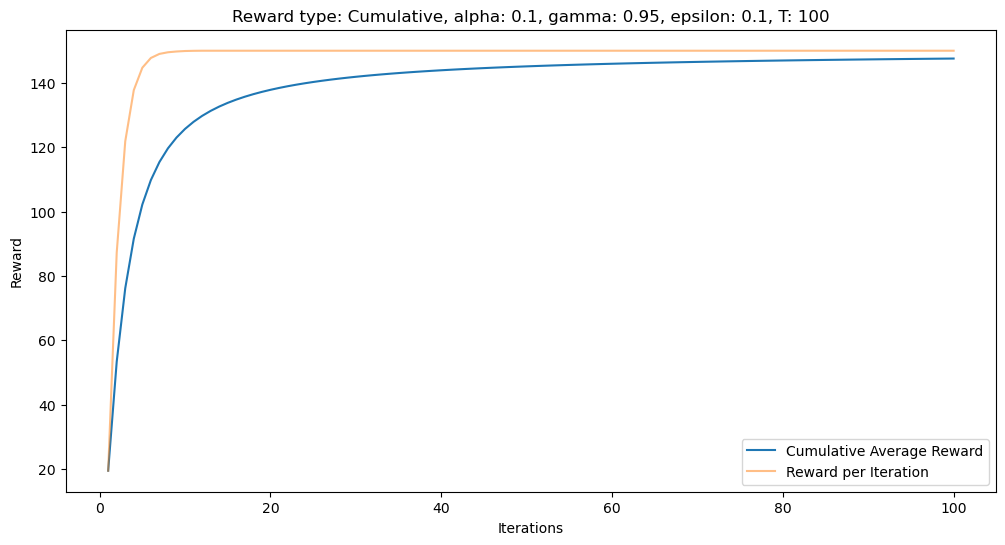

In [238]:
# Plotting the rewards
plt.figure(figsize=(12,6))
plt.plot(nElem, rewards_per_iteration_sum_avg, label='Cumulative Average Reward')
plt.plot(nElem, rewards_per_iteration, label='Reward per Iteration', alpha=0.5)
plt.xlabel('Iterations')
plt.ylabel('Reward')
plt.title(f"Reward type: {reward_type}, alpha: {alpha}, gamma: {gamma}, epsilon: {epsilon}, T: {T}")
plt.legend()
plt.show()

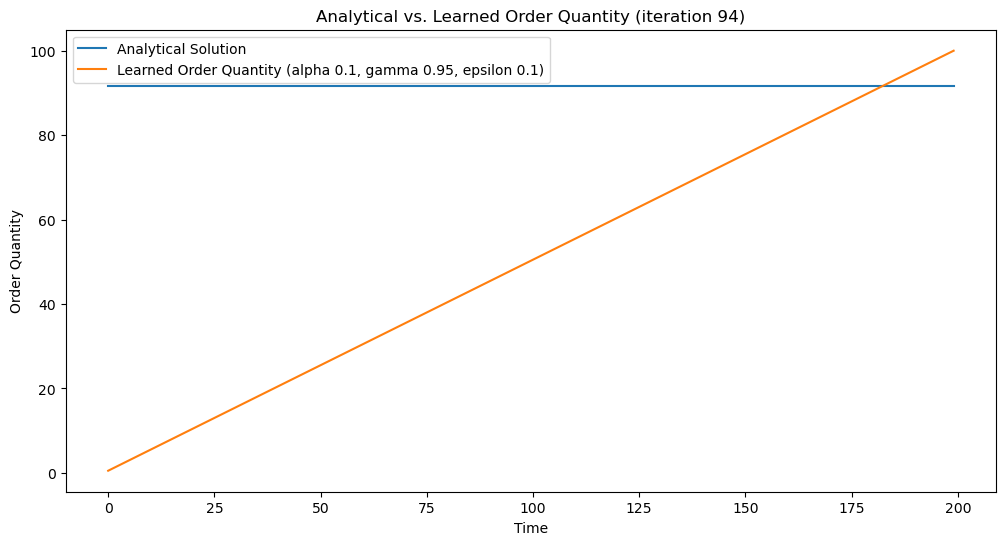

In [239]:
# Plotting the order quantities
ite = np.random.randint(0, trial_size)
order_quantity = learning_list_per_iteration[ite]
time = np.arange(len(order_quantity))

plt.figure(figsize=(12,6))
plt.plot(time, [optimal_order_quantity] * len(time), label='Analytical Solution')
plt.plot(time, order_quantity, label=f'Learned Order Quantity (alpha {alpha}, gamma {gamma}, epsilon {epsilon})')
plt.xlabel('Time')
plt.ylabel('Order Quantity')
plt.title(f'Analytical vs. Learned Order Quantity (iteration {ite})')
plt.legend()

---
# Dynamic Inventory Management

In [240]:
class DynamicInventoryModel:
    def __init__(self, state, T, holding_cost, shortage_cost, ordering_cost, demand_distribution):
        self.state = state
        self.T = T
        self.holding_cost = holding_cost
        self.ordering_cost = ordering_cost
        self.demand_distribution = demand_distribution
        self.history = {'inventory': [], 'order': [], 'cost': [], 'demand': []}

    def step(self, order_quantity):
        demand = np.random.choice(self.demand_distribution)
        ending_inventory = max(self.state['inventory'] + order_quantity - demand, 0)
        shortage = max(demand - (self.state['inventory'] + order_quantity), 0)
        holding_cost = self.holding_cost * shortage
        ordering_cost = self.ordering_cost * order_quantity
        total_cost = holding_cost + shortage_cost + ordering_cost

        self.state['inventory'] = ending_inventory
        self.history['inventory'].append(ending_inventory)
        self.history['order'].append(total_cost)
        self.history['cost'].append(total_cost)
        self.history['demand'].append(demand)

        return total_cost, ending_inventory
    
class InventoryPolicy:
    def __init__(self, model, reorder_point, order_up_to_level):
        self.model = model
        self.reorder_point = reorder_point
        self.order_up_to_level = order_up_to_level

    def run_policy(self):
        total_cost = 0
        for t in range(self.model.T):
            if self.model.state['inventory'] <= self.reorder_point:
                order_quantity = self.order_up_to_level - self.model.state['inventory']
            else:
                order_quantity = 0
            cost, _ = self.model.step(order_quantity)
            total_cost += cost
        return total_cost

Total cost over 20 periods: 1370
Inventory levels: [20, 40, 0, 0, 30, 10, 10, 0, 10, 0, 20, 0, 40, 10, 0, 20, 0, 20, 30, 0]
Order quantities: [5, 65, 5, 105, 105, 5, 85, 85, 105, 85, 105, 65, 105, 5, 85, 105, 65, 105, 65, 15]
Demand: [30, 10, 40, 50, 20, 20, 40, 50, 40, 50, 30, 50, 10, 30, 50, 30, 50, 30, 20, 40]
Costs: [5, 65, 5, 105, 105, 5, 85, 85, 105, 85, 105, 65, 105, 5, 85, 105, 65, 105, 65, 15]


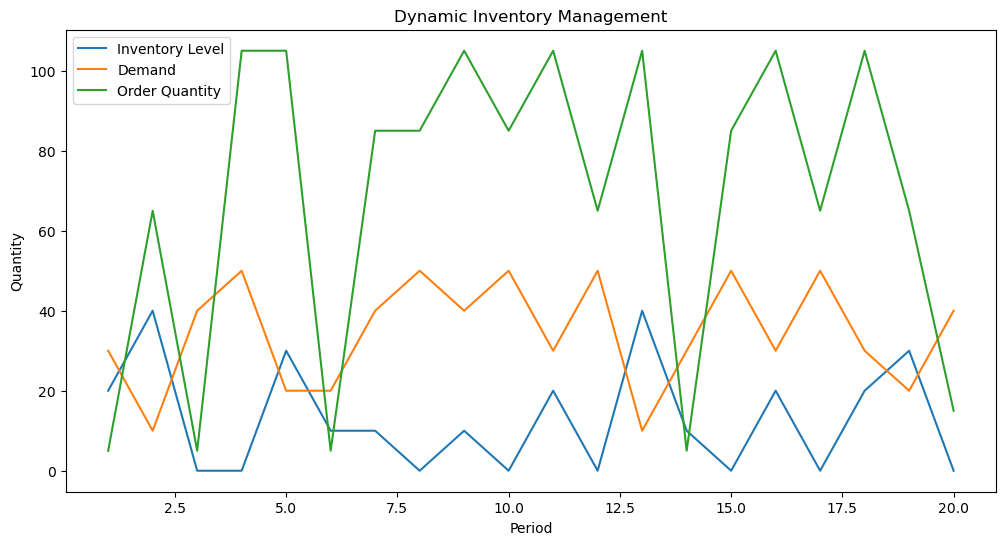

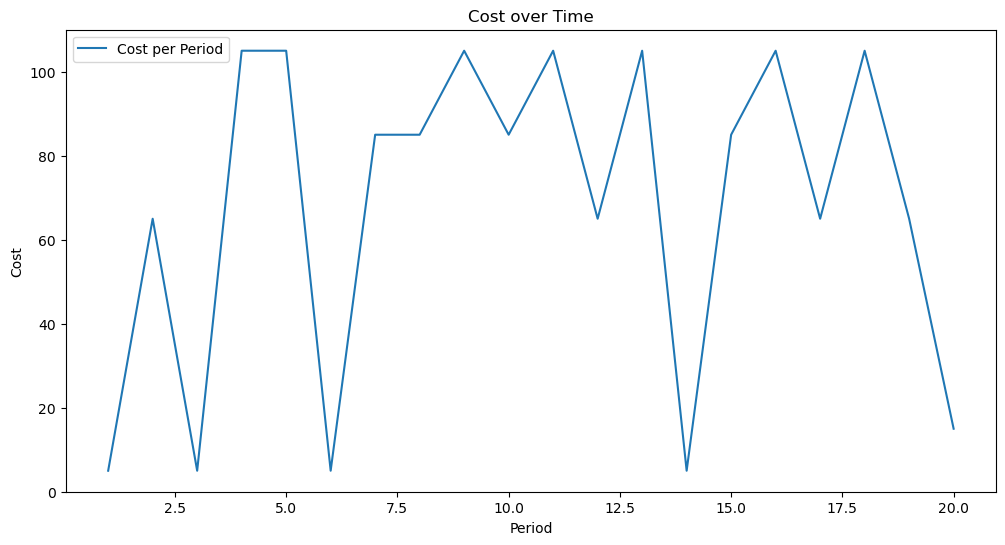

In [241]:
if __name__ == "__main__":
    # Define intial state and parameters
    initial_inventory = 50
    T = 20 # Number of periods
    holding_cost = 1
    shortage_cost = 5
    ordering_cost = 2
    demand_distribution = [10, 20, 30, 40, 50] # Possible demand values
    
    # Initialize model and policy
    initial_state = {'inventory' : initial_inventory}
    reorder_point = 20
    order_up_to_level = 50
    model = DynamicInventoryModel(initial_state, T, holding_cost, shortage_cost, ordering_cost, demand_distribution)
    policy = InventoryPolicy(model, reorder_point, order_up_to_level)

    # Run the policy
    total_cost = policy.run_policy()

    # Print results
    print(f'Total cost over {T} periods: {total_cost}')
    print('Inventory levels:', model.history['inventory'])
    print('Order quantities:', model.history['order'])
    print('Demand:', model.history['demand'])
    print('Costs:', model.history['cost'])

    # Plotting the results
    periods = np.arange(1, T+1)
    plt.figure(figsize=(12,6))
    plt.plot(periods, model.history['inventory'], label='Inventory Level')
    plt.plot(periods, model.history['demand'], label='Demand')
    plt.plot(periods, model.history['order'], label='Order Quantity')
    plt.xlabel('Period')
    plt.ylabel('Quantity')
    plt.title('Dynamic Inventory Management')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,6))
    plt.plot(periods, model.history['cost'], label='Cost per Period')
    plt.xlabel('Period')
    plt.ylabel('Cost')
    plt.title('Cost over Time')
    plt.legend()
    plt.show()

---
# Portfolio Management with SDA

In [242]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern

In [243]:
class AdvancedPortfolioManagementModel:
    def __init__(self, initial_capital, num_assets, T, historical_returns, transaction_cost, min_allocation, max_allocation):
        self.initial_capital = initial_capital
        self.num_assets = num_assets
        self.T = T
        self.historical_returns = historical_returns
        self.transaction_cost = transaction_cost
        self.min_allocations = min_allocations
        self.max_allocations = max_allocations
        self.state = {'capital':initial_capital, 'allocations': np.zeros(num_assets)}
        self.history = {'capital': [], 'allocations': [], 'returns': [], 'cost': []}

    def step(self, new_allocations):
        returns = np.random.multivariate_normal(np.mean(self.historical_returns, axis=0), np.cov(self.historical_returns.T))
        transaction_cost = self.transaction_cost * np.sum(np.abs(new_allocations - self.state['allocations']))
        portfolio_return = np.dot(new_allocations, returns)
        new_capital = self.state['capital'] * (1 + portfolio_return) - transaction_cost

        self.state['capital'] = new_capital
        self.state['allocations'] = new_allocations
        self.history['capital'].append(new_capital)
        self.history['allocations'].append(new_allocations)
        self.history['returns'].append(portfolio_return)
        self.history['cost'].append(transaction_cost)

        return new_capital, portfolio_return, transaction_cost

In [244]:
class AdvancedPortfolioPolicy:
    def __init__(self, model):
        self.model = model
        self.dynamic_risk_tolerance = 0.5 # Initial risk tolerance
        self.gpr = GaussianProcessRegressor(kernel=Matern(), n_restarts_optimizer=10)

    def run_policy(self):
        for t in range(self.model.T):
            if t == 0:
                new_allocations = np.random.dirichlet(np.ones(self.model.num_assets))
            else:
                self.adjust_risk_tolerance(t)
                new_allocations = self.optimize_allocation()
            capital, portfolio_return, transaction_cost = self.model.step(new_allocations)
        return self.model.history

    def adjust_risk_tolerance(self, t):
        # Adjust risk tolerance based on portfolio performance
        if self.model.state['capital'] < self.model.initial_capital * 0.8:
            self.dynamic_risk_tolerance = 0.7
        elif self.model.state['capital'] > self.model.initial_capital * 1.2:
            self.dynamic_risk_tolerance = 0.3
        else:
            self.dynamic_risk_tolerance = 0.5

    def optimize_allocation(self):
        mean_returns = np.mean(self.model.historical_returns, axis=0)
        cov_matrix = np.cov(self.model.historical_returns.T)
        num_assets = self.model.num_assets
        def objective(weights):
            portfolio_return = np.dot(weights, mean_returns)
            portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            return - (portfolio_return - self.dynamic_risk_tolerance * portfolio_risk)
        
        constraints = (
            {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},
            {'type': 'ineq', 'fun': lambda weights: weights - self.model.min_allocations},
            {'type': 'ineq', 'fun': lambda weights: self.model.max_allocations - weights},
        )
        bounds = tuple((0,1) for _ in range(num_assets))
        result = minimize(objective, num_assets * [1. / num_assets,], bounds=bounds, constraints=constraints)
        return result.x
    
    def cvar_objective(self, weights, alpha=0.95):
        portfolio_returns = np.dot(self.model.historical_returns, weights)
        sorted_returns = np.sort(portfolio_returns)
        var_index = int((1 - alpha) * len(sorted_returns))
        var = sorted_returns[var_index]
        cvar = np.mean(sorted_returns[:var_index])
        return -cvar

Final capital after 20 periods: 13891.262021874369
Capital over time: [81903.46991942191, 71567.86798913783, 87330.66980653057, 85144.83146470632, 102259.18811255792, 105509.51100691129, 149820.21493373282, 136231.88912004532, 175359.04816977255, 152970.24311251772, 192932.62861186216, 161503.96461650112, 36596.24451631582, 30067.230469436585, 27845.33831058775, 22435.773955633475, 25964.466509366852, 23304.9158030875, 21369.779278179532, 13891.262021874369]
Allocations over time: [array([0.02024609, 0.48684785, 0.18202905, 0.31087701]), array([0.42805134, 0.30058138, 0.12402009, 0.14734719]), array([0.42231122, 0.30530193, 0.13408   , 0.13830685]), array([0.42805134, 0.30058138, 0.12402009, 0.14734719]), array([0.42805134, 0.30058138, 0.12402009, 0.14734719]), array([0.42805134, 0.30058138, 0.12402009, 0.14734719]), array([0.42805134, 0.30058138, 0.12402009, 0.14734719]), array([0.44228319, 0.28948649, 0.10010737, 0.16812295]), array([0.44228319, 0.28948649, 0.10010737, 0.16812295]), 

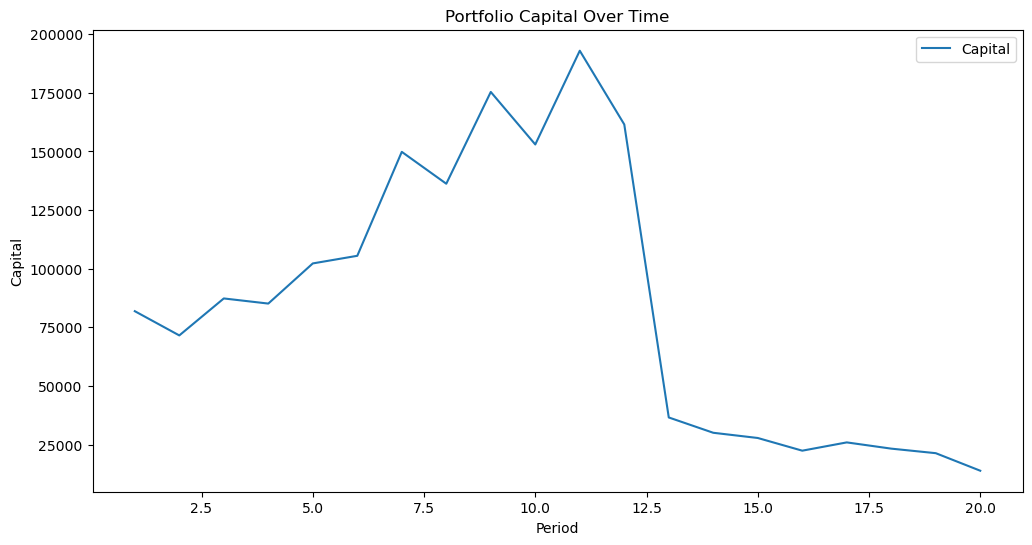

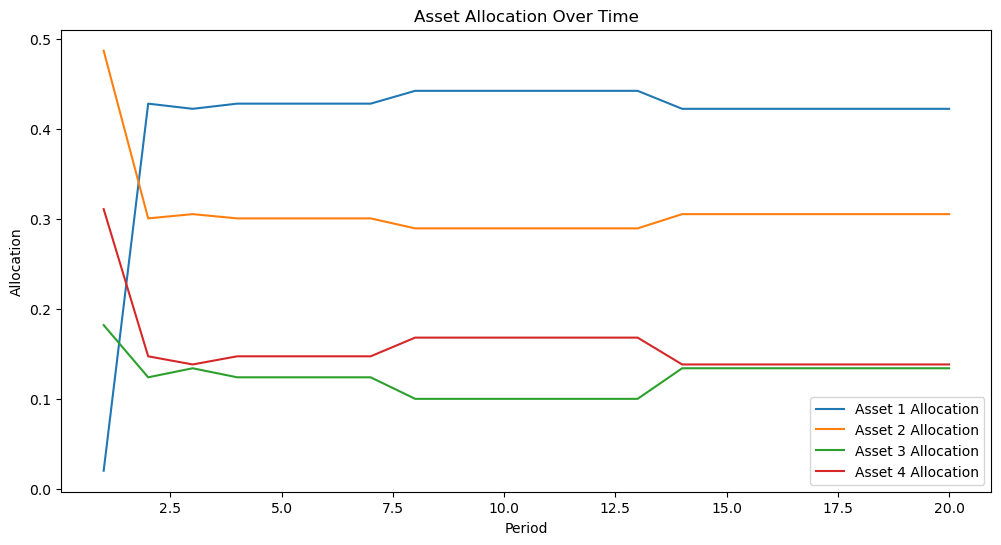

In [246]:
if __name__ == '__main__':
    # Define initial state and parameters
    initial_capital = 100000
    num_assets = 4
    T = 20 # Number of periods
    # Use more realistic historical returns
    historial_returns = np.random.multivariate_normal([0.01, 0.015, 0.02, 0.025], np.diag([0.1,0.2,0.3,0.4]), size=100)
    transaction_cost = 0.001 # 0.1% transaction cost
    min_allocations = np.array([0.1,0.1,0.1,0.1])
    max_allocations = np.array([0.5,0.5,0.5,0.5])

    # Initialize model and policy
    model = AdvancedPortfolioManagementModel(initial_capital, num_assets, T, historial_returns, transaction_cost, min_allocations, max_allocations)
    policy = AdvancedPortfolioPolicy(model)

    # Run the policy
    history = policy.run_policy()

    # Print results
    print(f'Final capital after {T} periods: {model.state["capital"]}')
    print('Capital over time:', history['capital'])
    print('Allocations over time:', history['allocations'])
    print('Returns over time:', history['returns'])
    print('Costs over time:', history['cost'])

    # Plotting the results
    periods = np.arange(1, T + 1)
    plt.figure(figsize=(12,6))
    plt.plot(periods, history['capital'], label='Capital')
    plt.xlabel('Period')
    plt.ylabel('Capital')
    plt.title('Portfolio Capital Over Time')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12,6))
    for i in range(num_assets):
        plt.plot(periods, [alloc[i] for alloc in history['allocations']], label=f'Asset {i+1} Allocation')
    plt.xlabel('Period')
    plt.ylabel('Allocation')
    plt.title('Asset Allocation Over Time')
    plt.legend()
    plt.show()